In [1]:
import json
import numpy as np
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
# import glmnet_python
# from glmnet_python import glmnet
# from glmnet_python import glmnetPredict
# from glmnet_python import glmnetPlot
# from glmnet_python import cvglmnet
# from glmnet_python import cvglmnetPredict
# from glmnet_python import cvglmnetPlot
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import codecs
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg




In [2]:
# VARIABLES TO ADJUST
# 'Mugs', 'Plates', 'Geometric', 'Cutlery', 'Ball'
family_to_select = 'Plates'
target = 'Index MPJ'
num_bins = 20
cv = 5
# C_par [0.2, 0.5, 1, 1.25, 1.5]
C_par = 0.2
l1vsl2 = 1


In [3]:
# CONSTANTS

obj_fam = dict(
    CeramicMug = 'Mugs',
    Glass = 'Mugs',
    MetalMug = 'Mugs',
    CeramicPlate = 'Plates',
    MetalPlate = 'Plates',
    PlasticPlate = 'Plates',
    Cube = 'Geometric',
    Cylinder ='Geometric',
    Triangle ='Geometric',
    Fork = 'Cutlery',
    Knife ='Cutlery',
    Spoon ='Cutlery',
    PingPongBall = 'Ball',
    SquashBall='Ball',
    TennisBall='Ball'
)

kin_labels = ["Thumb Rotate", "Thumb MPJ", "Thumb IJ", "Index MPJ", "Index PIJ", "Middle MPJ", "Middle PIJ", "Ring MPJ", "Ring PIJ", "Pinkie MPJ", "Pinkie PIJ", "Palm Arch", "Wrist Pitch", "Wrist Yaw", "Index Abd", "Pinkie Abd", "Ring Abd", "Middle Abd", "Thumb Abd"]
emg_labels = ['emg' + str(i) for i in range(0,64)]



In [4]:
# READING FILES AND CREATING DATASET
file_kin = "./PyData/filtered_data.json"
file_eps = "./PyData/ep_labels.json"
file_task = "./PyData/task_labels.json"
file_emg = "./PyData/emg_data.json"

with open(file_kin, "r") as f:
    kin_data = json.load(f)  # data[subjects][trials][joints]

with open(file_eps, "r") as g:
    eps = json.load(g)  # eps[subjects][trials]

with open(file_task, "r") as h:
    task = json.load(h)  # task[subjects][trials]

with open(file_emg, "r") as f:
    emg_data = json.load(f)  # data[subjects][trials][sensors]
    
    
        

In [5]:
# VECTORIZING DATA

vectorized_task = [x for sublist in task for x in sublist]  # Vectorization of tasks
vectorized_eps = [x for sublist in eps for x in sublist]  # Vectorization of eps
vectorized_kin = [x for sublist in kin_data for x in sublist]  # Vectorization of trials
vectorized_kin = np.array(vectorized_kin, dtype=float) # Conversion to float to replace 'None' with 'NaN'
vectorized_emg = [x for sublist in emg_data for x in sublist]  # Vectorization of trials
vectorized_emg = np.array(vectorized_emg, dtype=float) # Conversion to float to replace 'None' with 'NaN'
given_object = [x.split("_")[0] for x in vectorized_task]  # Vectorized given objects
ask_object = [x.split("_")[1] for x in vectorized_task]  # Vectorized asked objects


In [6]:
# CREATE PANDAS DATAFRAME AND GENERATE TRIAL AND EP INDEX

# aux = np.concatenate([vectorized_kin, vectorized_emg], axis=1)
# labs = np.concatenate([kin_labels, emg_labels])

# JUST FOR DEBUGGING
aux = vectorized_kin
labs = kin_labels

new_df = pd.DataFrame(aux, columns=labs)
new_df['EPs'] = vectorized_eps
new_df['Task'] = vectorized_task
new_df['Given'] = given_object
new_df['Asked'] = ask_object
new_df['Family'] = [obj_fam[x] for x in given_object]

tr = 0
trial = np.zeros((len(new_df['Task']),), dtype=int)
trial_list = list()
objects_list = list()
trial_list.append(tr)
objects_list.append(given_object[0])

for i in range(1,len(new_df['Task'])):
    if vectorized_task[i] != vectorized_task[i-1]:
        tr += 1
        trial_list.append(tr)
        objects_list.append(given_object[i])
    trial[i] = tr
        
new_df['Trial number'] = trial        
new_df['Trial number'] = new_df['Trial number'].astype(str)               

ep = 0
eps = np.zeros((len(new_df['EPs']),), dtype=int)

for j in range(1,len(new_df['EPs'])):
    if vectorized_task[j] != vectorized_task[j-1]: # EP to 0 if we change trial
        ep = 0
    elif vectorized_eps[j] != vectorized_eps[j-1]:
        ep += 1
    eps[j] = ep 
        
new_df['EP number'] = eps        
new_df['EP number'] = new_df['EP number'].astype(str)


In [7]:
# SELECT DATAPOINTS BY FAMILY

sel_df = new_df.loc[new_df['Family'] == family_to_select]

selected_trials = np.unique(sel_df['Trial number'])
selected_objects = [np.unique(sel_df['Given'].loc[sel_df['Trial number'] == tri]) for tri in selected_trials]

selected = pd.DataFrame(list(zip(selected_trials,selected_objects)), columns=['Trial', 'Object'])


In [8]:
# K-FOLD, Z-SCORE, BIN CREATION, CLASSIFICATION AND STATISTICAL TEST ¿¿¿???

# STRATIFIED K-FOLD CROSS VALIDATION
skf = StratifiedKFold(n_splits=cv)

total_acc = list() # TOTAL ACCURACY

for train, test in skf.split(selected['Trial'].astype(int), selected['Object'].astype(str)): 
    
    # TRAIN/TEST SPLIT
    trials_train = selected.iloc[train]['Trial'].array
    train_df = sel_df.loc[sel_df['Trial number'].isin(trials_train)]
    
    trials_test = selected.iloc[test]['Trial'].array
    test_df = sel_df.loc[sel_df['Trial number'].isin(trials_test)]
    
    # Z-SCORE NORMALIZATION, ADD MISSING (no numerical) COLUMNS AND REARRANGE DATAFRAME (to fit original order)
#     train_z = train_df[train_df.select_dtypes(include=[np.number]).columns].apply(stats.zscore,nan_policy='omit')
#     train_z['EPs'] = train_df['EPs']
#     train_z['Task'] = train_df['Task']
#     train_z['Given'] = train_df['Given']
#     train_z['Asked'] = train_df['Asked']
#     train_z['Family'] = train_df['Family']
#     train_z['Trial number'] = train_df['Trial number']
#     train_z['EP number'] = train_df['EP number']
#     train_z = train_z.reindex(columns=train_df.columns)
    
#     test_z = test_df[test_df.select_dtypes(include=[np.number]).columns].apply(stats.zscore,nan_policy='omit')
#     test_z['EPs'] = test_df['EPs']
#     test_z['Task'] = test_df['Task']
#     test_z['Given'] = test_df['Given']
#     test_z['Asked'] = test_df['Asked']
#     test_z['Family'] = test_df['Family']
#     test_z['Trial number'] = test_df['Trial number']
#     test_z['EP number'] = test_df['EP number']
#     test_z = test_z.reindex(columns=test_df.columns)

    train_z = train_df
    test_z = test_df

    # DIVIDE IN BINS AND COMPUTE MEAN
    train_list = list() # One row per EP
    train_lab = list() # Labels 
    
    for it1 in trials_train: # Loop over trials
        
        each_train_trial = train_z.loc[train_z['Trial number'] == it1] 
        eps_in_trial = np.unique(each_train_trial['EP number'])

        for it2 in eps_in_trial: # Loop over EPs in each trial

            each_ep_train = each_train_trial.loc[each_train_trial['EP number'] == it2]

            ep_to_array_train = each_ep_train[each_ep_train.select_dtypes(include=[np.number]).columns]

            split_ep_train = np.array_split(ep_to_array_train, num_bins) # (timepoints per EP) x (number of sensors (kin + emg = 83))
            
            ep_mean_train = [np.nanmean(x, axis=0) for x in split_ep_train] # (number of bins) x (number of sensors (kin + emg = 83))

            flat_ep_train = [item for sublist in ep_mean_train for item in sublist] # UNIDIMENSIONAL ARRAY: 1 x (number of bins x number of sensors)
            train_list.append(flat_ep_train)
            train_lab.append(each_train_trial['Given'].iloc[0])
    
    test_list = list() # One row per EP
    test_lab = list() # Labels 
    
    for ite1 in trials_test: # Loop over trials
        
        each_test_trial = test_z.loc[test_z['Trial number'] == ite1] 
        eps_in_test = np.unique(each_test_trial['EP number'])

        for ite2 in eps_in_test: # Loop over EPs in each trial

            each_ep_test = each_test_trial.loc[each_test_trial['EP number'] == ite2]

            ep_to_array_test = each_ep_test[each_ep_test.select_dtypes(include=[np.number]).columns]

            split_ep_test = np.array_split(ep_to_array_test, num_bins) # (timepoints per EP) x (number of sensors (kin + emg = 83))
            
            ep_mean_test = [np.nanmean(x, axis=0) for x in split_ep_test] # (number of bins) x (number of sensors (kin + emg = 83))

            flat_ep_test = [item for sublist in ep_mean_test for item in sublist] # UNIDIMENSIONAL ARRAY: 1 x (number of bins x number of sensors)
            test_list.append(flat_ep_test)
            test_lab.append(each_test_trial['Given'].iloc[0])
            
    # REMOVE ROWS WITH NANs
    dataframe_train = pd.DataFrame(train_list)
    dataframe_train['Given'] = train_lab
    dataframe_train_clean = dataframe_train.dropna()
    
    dataframe_test = pd.DataFrame(test_list)
    dataframe_test['Given'] = test_lab
    dataframe_test_clean = dataframe_test.dropna()
    
    # LOGISTIC REGRESSION
    # log_model = LogisticRegression(penalty='elasticnet', C=C_par, solver='saga', max_iter=25000, multi_class='multinomial', n_jobs=-1, l1_ratio=l1vsl2)
    # log_model.fit(dataframe_train_clean.drop('Given', axis=1), dataframe_train_clean['Given'])
    # weights = log_model.coef_
    # print(weights)
    # print("Size Weights: ", weights.shape)
    # print("Classes: ", log_model.classes_)
    
#     # WRITE WEIGHTS INTO A FILE
#     file_name = "./PyData/KIN_EMG_Norm_weights_N05_" + family_to_select + ".csv"
    # weights = log_model.coef_
    # print(weights.shape)
    # resh = weights.reshape((weights.shape[0], int(weights.shape[1]/num_bins), num_bins))
    # print(len(resh))
    # print(len(resh[0]))
    # print(len(resh[0][0]))
    # mean_resh = np.mean(np.abs(resh), axis=2) # One row per class
    # aux_mean = np.mean(mean_resh, axis=0) # Mean of weights per class
    # print(aux_mean)
    # print(len(mean_resh))
    # print(len(mean_resh[0]))
#     df = pd.DataFrame(mean_resh, index=log_model.classes_)
#     df.to_csv(file_name, index=True, header=None, mode='a')
#     print("FILE UPDATED")
    
    # GET PREDICTIONS
    # pred = log_model.predict_proba(dataframe_test_clean.drop('Given', axis=1))
    # cl = log_model.classes_
    # print(cl)
    # print(pred[0:4])
    # print(np.argmax(pred[0:4], axis=1))
    # print(dataframe_test_clean.iloc[0:4]['Given'])
    # hits = 0
    # for i in range(len(pred)):
    #     if cl[np.argmax(pred[i])] == dataframe_test_clean.iloc[i]['Given']:
    #         hits += 1
    # acc = round((hits/dataframe_test_clean.shape[0])*100, 2)
    # total_acc.append(acc)
    # print("Hits: ", hits, " out of ", dataframe_test_clean.shape[0], ". ", acc, "%")

# print("\n|| FAMILY: ", family_to_select, " || Mean accuracy after ", cv, " folds with ", num_bins, " bins per EP: ", round(np.mean(total_acc), 2), " % ||")
# print("P-value less: ", round(stats.ttest_1samp(total_acc, 33.33,alternative='less').pvalue, 5))
# print("P-value greater: ", round(stats.ttest_1samp(total_acc, 33.33, alternative='greater').pvalue, 5))
# print("DONE!")


/tmp/ipykernel_516/283211471.py:58: RuntimeWarning: Mean of empty slice
  ep_mean_train = [np.nanmean(x, axis=0) for x in split_ep_train] # (number of bins) x (number of sensors (kin + emg = 83))
/tmp/ipykernel_516/283211471.py:80: RuntimeWarning: Mean of empty slice
  ep_mean_test = [np.nanmean(x, axis=0) for x in split_ep_test] # (number of bins) x (number of sensors (kin + emg = 83))
/tmp/ipykernel_516/283211471.py:58: RuntimeWarning: Mean of empty slice
  ep_mean_train = [np.nanmean(x, axis=0) for x in split_ep_train] # (number of bins) x (number of sensors (kin + emg = 83))
/tmp/ipykernel_516/283211471.py:80: RuntimeWarning: Mean of empty slice
  ep_mean_test = [np.nanmean(x, axis=0) for x in split_ep_test] # (number of bins) x (number of sensors (kin + emg = 83))
/tmp/ipykernel_516/283211471.py:58: RuntimeWarning: Mean of empty slice
  ep_mean_train = [np.nanmean(x, axis=0) for x in split_ep_train] # (number of bins) x (number of sensors (kin + emg = 83))
/tmp/ipykernel_516/28321

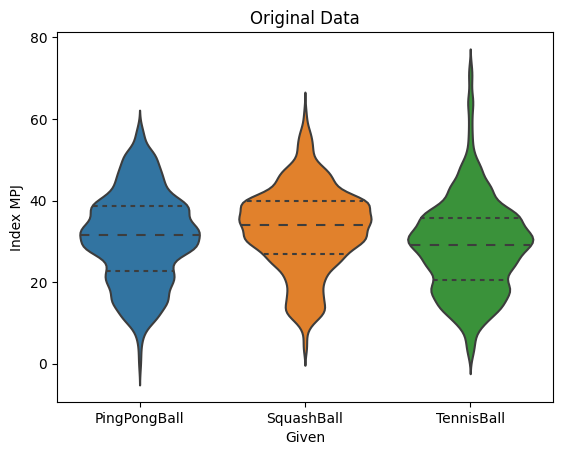

In [9]:
# check data distribution

# original data
sns.violinplot(data=sel_df, x="Given", y=target, inner="quartile").set(title='Original Data')
# sns.set(rc={'figure.figsize':(48,27)})
plt.show()

# bin data
# bin_df = pd.concat([dataframe_train_clean, dataframe_test_clean], ignore_index=True)
# sns.violinplot(data=bin_df, x="Given", y=target, inner="quartile").set(title='Bin Data')
# sns.set(rc={'figure.figsize':(48,27)})
# plt.show()